# Mount drive

In [4]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Install dependencies

In [5]:
!pip install lambeq[extras]

# Import libraries

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# QNLP
from lambeq.tokeniser import SpacyTokeniser
from lambeq import BobcatParser, spiders_reader, cups_reader, TreeReader, TreeReaderMode, stairs_reader
from lambeq import Rewriter, SimpleRewriteRule, remove_cups, AtomicType, IQPAnsatz
from discopy.tensor import Dim
from discopy.grammar.pregroup import Cap, Id, Diagram
N = AtomicType.NOUN
S = AtomicType.SENTENCE
P = AtomicType.PREPOSITIONAL_PHRASE
C = AtomicType.CONJUNCTION

# Training
from lambeq import NumpyModel, QuantumTrainer, SPSAOptimizer, Dataset, CrossEntropyLoss, PennyLaneModel, PytorchTrainer
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

# SEED for reproducibility
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Load data

In [7]:
QUANTUM_PATH = '/content/drive/MyDrive/Tesi/Master-Thesis/data/processed/quantum.csv'
CLASSICAL_PATH = '/content/drive/MyDrive/Tesi/Master-Thesis/data/processed/classical.csv'

df = pd.read_csv(CLASSICAL_PATH, index_col=False)

# Create string-diagrams
Uncomment rows for different readers

In [8]:
def create_multi_diagrams(df, reader):
    diagrams, targets = [], []
    for _, row in enumerate(df.to_numpy()):
        sentence, target = row[0], row[1]
        try:
            diagrams.append(reader.sentence2diagram(sentence))
        except Exception as e:
            print(sentence)
            print(e)
            continue
        if target == "US":
            targets.append([1.0, 0.0, 0.0, 0.0])
        elif target == "SE":
            targets.append([0.0, 1.0, 0.0, 0.0])
        elif target == "O":
            targets.append([0.0, 0.0, 1.0, 0.0])
        elif target == "PE":
            targets.append([0.0, 0.0, 0.0, 1.0])
    return diagrams, targets

reader = spiders_reader
# reader = cups_reader
# reader = stairs_reader
# reader = TreeReader(ccg_parser=BobcatParser, mode = TreeReaderMode.RULE_TYPE)

# reader = BobcatParser(root_cats=['S'])

diagrams, targets = create_multi_diagrams(df, reader)

# Rewrite string-diagrams
This step is not performed for linear readers (spiders, cups, etc.).

In [9]:
# def normalize_diagrams(diagrams):
#     normalized_diagrams = []
#     for i, diagram in enumerate(diagrams):
#         try:
#             normalized_diagrams.append(rewriter(diagram).normal_form())
#         except Exception as e:
#             print(e)
#             diagram.draw()
#             continue
#     return normalized_diagrams


# rewriter = Rewriter(['prepositional_phrase', 'determiner', 'connector', 'auxiliary', 'preadverb', 'curry', 'coordination'])
# diagrams = normalize_diagrams(diagrams)

# Parameterize diagrams
Uncomment rows for different anstaze

In [21]:
def create_circuits(diagrams, ansatz):
    circuits = []
    for i, diagram in enumerate(diagrams):
        try:
            circuits.append(ansatz(remove_cups(diagram)))
        except Exception as e:
            print(e)
            diagram.draw(figsize=(8,5), fontsize=8)
            continue
    return circuits

ob_map = {
    AtomicType.SENTENCE: 2,
    AtomicType.NOUN: 1,
    AtomicType.PREPOSITIONAL_PHRASE: 1,
}

ansatz = IQPAnsatz(ob_map, n_layers=5, n_single_qubit_params=3)
circuits = create_circuits(diagrams, ansatz)

# # check for codomain errors
# for i,c in enumerate(se_circuits):
#     if str(c.cod) != 'qubit @ qubit':
#         print(se_df.loc[[i]])
#         se_normalized_diagrams[i].draw()

# Define evalutation metrics

In [22]:
def accuracy(y_hat, y):
    y_true = torch.argmax(y, dim=1)
    y_pred = torch.argmax(y_hat, dim=1)
    return accuracy_score(y_true, y_pred)

def precision(y_hat, y):
    y_true = torch.argmax(y, dim=1)
    y_pred = torch.argmax(y_hat, dim=1)
    return precision_score(y_true, y_pred, average='weighted', zero_division=1)

def recall(y_hat, y):
    y_true = torch.argmax(y, dim=1)
    y_pred = torch.argmax(y_hat, dim=1)
    return recall_score(y_true, y_pred, average='weighted', zero_division=1)

def f1score(y_hat, y):
    y_true = torch.argmax(y, dim=1)
    y_pred = torch.argmax(y_hat, dim=1)
    return f1_score(y_true, y_pred, average='weighted', zero_division=1)

eval_metrics = {"prec": precision, "rec": recall, "acc": accuracy, "f1": f1score}

# Define model

In [23]:
class QuantumModel(PennyLaneModel):
    def __init__(self, **kwargs):
        PennyLaneModel.__init__(self, **kwargs)

    def forward(self, input):
        preds = self.get_diagram_output(input)
        return preds.reshape(-1, 4)

# Training

In [24]:
EPOCHS = 50
SPLIT = 10
EARLY_STOPPING = None

custom_primary = '#007FFF'
custom_secondary = '#FF6666'

## Grid Search

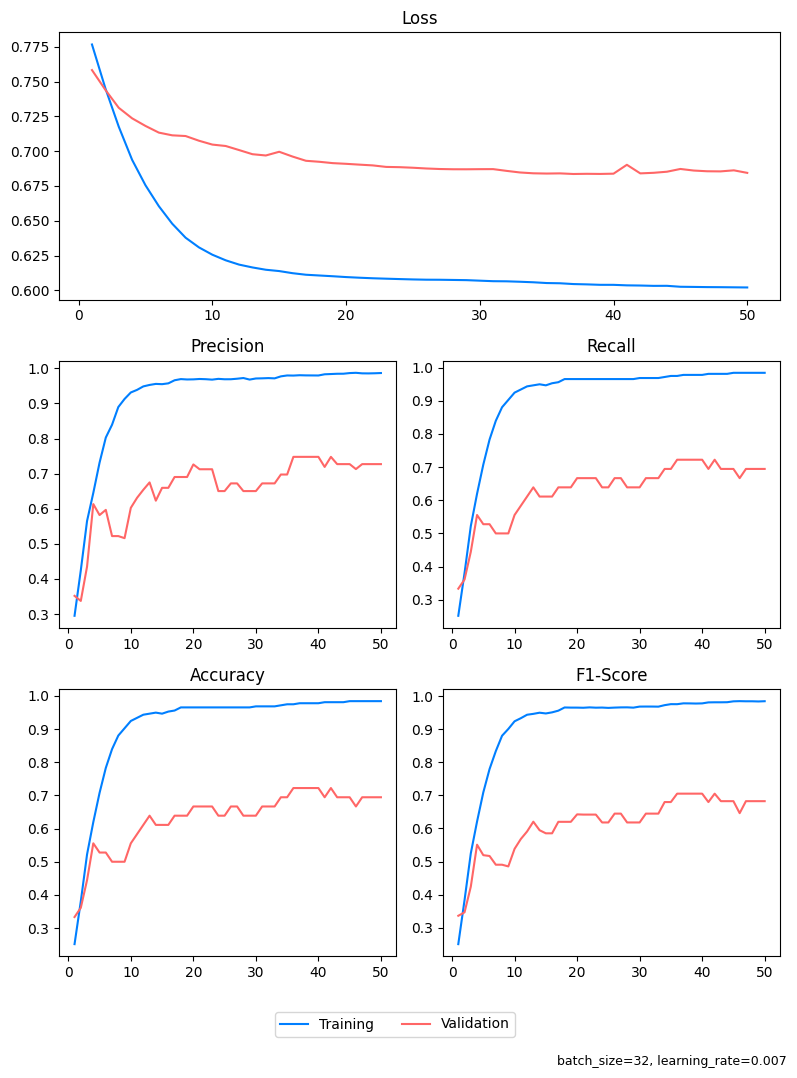

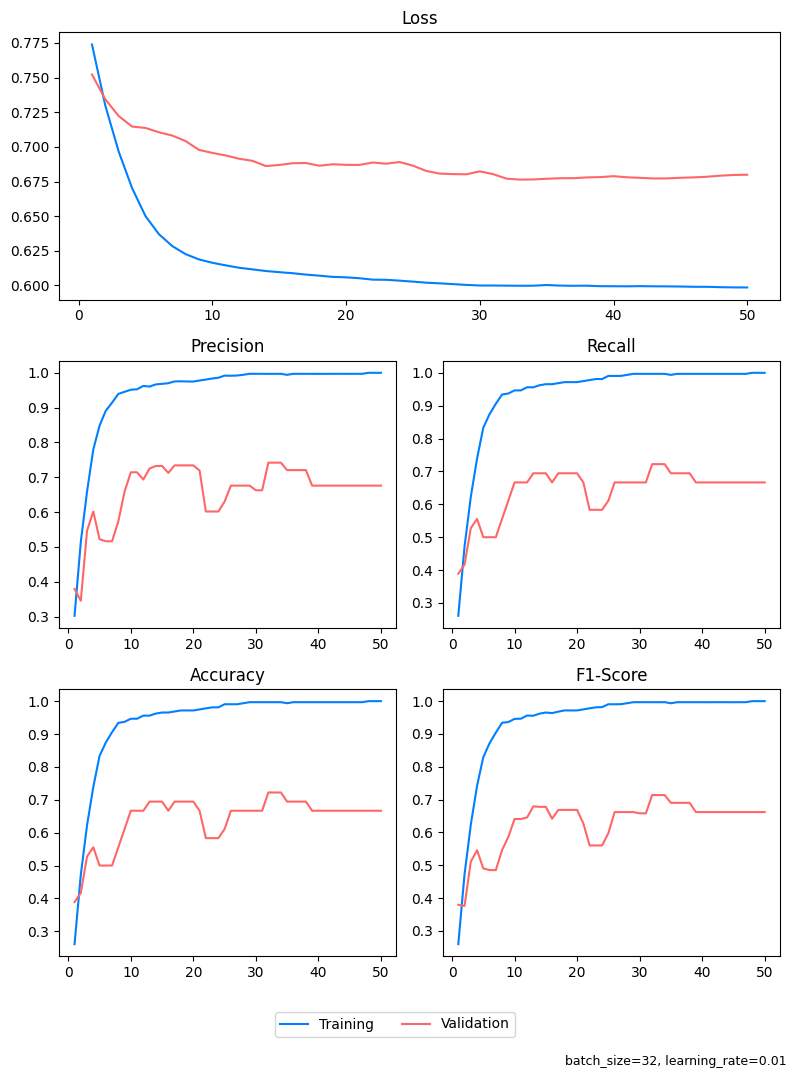

In [ ]:
for bs in [32, 64]:
    for lr in [7e-3, 1e-2, 3e-2, 5e-2]:
        X_train_grid, X_val_grid, y_train_grid, y_val_grid = train_test_split(circuits, targets, test_size=1/SPLIT, random_state=SEED)
        train_dataset = Dataset(X_train_grid, y_train_grid, batch_size=bs)
        val_dataset =  Dataset(X_val_grid, y_val_grid, shuffle=False)

        model = QuantumModel.from_diagrams(circuits)
        model.initialise_weights()

        trainer = PytorchTrainer(
                        model=model,
                        loss_function=torch.nn.BCEWithLogitsLoss(),
                        optimizer=torch.optim.AdamW,
                        learning_rate=lr,
                        epochs=EPOCHS,
                        evaluate_functions=eval_metrics,
                        evaluate_on_train=True,
                        verbose='suppress',
                        seed=SEED
                    )

        trainer.fit(train_dataset, val_dataset, log_interval=25)

        range_ = np.arange(1, len(trainer.train_epoch_costs) + 1)

        fig, axes = plt.subplot_mosaic('AA;BC;DE', figsize=(8, 10))

        axes['A'].plot(range_, trainer.train_epoch_costs, color=custom_primary, label='Training Loss')
        axes['A'].plot(range_, trainer.val_costs, color=custom_secondary, label='Validation Loss')
        axes['A'].set_title('Loss')

        axes['B'].plot(range_, trainer.train_eval_results['prec'], color=custom_primary, label='Training Precision')
        axes['B'].plot(range_, trainer.val_eval_results['prec'], color=custom_secondary, label='Validation Precision')
        axes['B'].set_title('Precision')

        axes['C'].plot(range_, trainer.train_eval_results['rec'], color=custom_primary, label='Training Recall')
        axes['C'].plot(range_, trainer.val_eval_results['rec'], color=custom_secondary, label='Validation Recall')
        axes['C'].set_title('Recall')

        axes['D'].plot(range_, trainer.train_eval_results['acc'], color=custom_primary, label='Training Accuracy')
        axes['D'].plot(range_, trainer.val_eval_results['acc'], color=custom_secondary, label='Validation Accuracy')
        axes['D'].set_title('Accuracy')

        axes['E'].plot(range_, trainer.train_eval_results['f1'], color=custom_primary, label='Training F1-Score')
        axes['E'].plot(range_, trainer.val_eval_results['f1'], color=custom_secondary, label='Validation F1-Score')
        axes['E'].set_title('F1-Score')

        for _, ax in axes.items():
            ax.legend().set_visible(False)

        fig.legend(['Training', 'Validation'], loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=2)
        plt.figtext(0.99, -0.07, f'batch_size={bs}, learning_rate={lr}', horizontalalignment='right', fontsize=9, color='black')

        plt.tight_layout()
        plt.savefig(f"/content/drive/MyDrive/Tesi/Master-Thesis/figures/grid-search/quantum/multi/{bs}-{lr}.pdf", format="pdf", bbox_inches="tight")
        plt.show()

## K-fold cross validation
After grid-search we choose:

In [15]:
LEARNING_RATE = 1e-2
BATCH_SIZE = 64

Processing Fold 1 ...


/usr/local/lib/python3.10/dist-packages/lambeq/training/dataset.py:108: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  backend.array(
Epoch 1:   train/loss: 1.3937   valid/loss: 1.3614   train/acc: 0.2264   train/f1: 0.2320   valid/acc: 0.3611   valid/f1: 0.3563
Epoch 2:   train/loss: 1.2794   valid/loss: 1.3152   train/acc: 0.3428   train/f1: 0.3424   valid/acc: 0.3611   valid/f1: 0.3602
Epoch 3:   train/loss: 1.3216   valid/loss: 1.2716   train/acc: 0.4591   train/f1: 0.4614   valid/acc: 0.4167   valid/f1: 0.4187
Epoch 4:   train/loss: 1.2587   valid/loss: 1.2344   train/acc: 0.5283   train/f1: 0.5314   valid/acc: 0.4167   valid/f1: 0.4182
Epoch 5:   train/loss: 1.0492   valid/loss: 1.2021   train/acc: 0.6101   train/f1: 0.6048   valid/acc: 0.5000   valid/f1: 0.5088
Epoch 6:

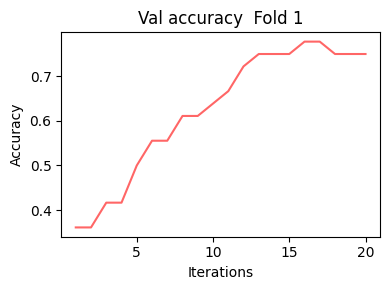

Processing Fold 2 ...


Epoch 1:   train/loss: 1.3714   valid/loss: 1.4416   train/acc: 0.2453   train/f1: 0.2424   valid/acc: 0.2500   valid/f1: 0.2363
Epoch 2:   train/loss: 1.3496   valid/loss: 1.4108   train/acc: 0.3553   train/f1: 0.3538   valid/acc: 0.2778   valid/f1: 0.2577
Epoch 3:   train/loss: 1.2156   valid/loss: 1.3575   train/acc: 0.4497   train/f1: 0.4589   valid/acc: 0.3056   valid/f1: 0.2886
Epoch 4:   train/loss: 1.1296   valid/loss: 1.3022   train/acc: 0.5503   train/f1: 0.5483   valid/acc: 0.3889   valid/f1: 0.3716
Epoch 5:   train/loss: 1.0821   valid/loss: 1.2637   train/acc: 0.6195   train/f1: 0.6146   valid/acc: 0.4444   valid/f1: 0.4360
Epoch 6:   train/loss: 1.0868   valid/loss: 1.2338   train/acc: 0.6730   train/f1: 0.6739   valid/acc: 0.5000   valid/f1: 0.4938
Epoch 7:   train/loss: 0.9655   valid/loss: 1.2067   train/acc: 0.7358   train/f1: 0.7368   valid/acc: 0.5278   valid/f1: 0.5198
Epoch 8:   train/loss: 1.0515   valid/loss: 1.1762   train/acc: 0.7830   train/f1: 0.7865   valid

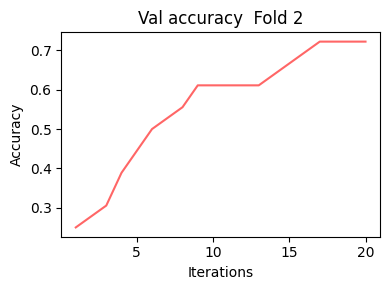

Processing Fold 3 ...


Epoch 1:   train/loss: 1.4261   valid/loss: 1.4519   train/acc: 0.2516   train/f1: 0.2454   valid/acc: 0.2500   valid/f1: 0.2426
Epoch 2:   train/loss: 1.3993   valid/loss: 1.4159   train/acc: 0.3428   train/f1: 0.3447   valid/acc: 0.2500   valid/f1: 0.2426
Epoch 3:   train/loss: 1.2468   valid/loss: 1.3721   train/acc: 0.4434   train/f1: 0.4477   valid/acc: 0.3056   valid/f1: 0.3028
Epoch 4:   train/loss: 1.1994   valid/loss: 1.3191   train/acc: 0.5503   train/f1: 0.5475   valid/acc: 0.3889   valid/f1: 0.3825
Epoch 5:   train/loss: 1.0541   valid/loss: 1.2668   train/acc: 0.6226   train/f1: 0.6216   valid/acc: 0.4167   valid/f1: 0.4127
Epoch 6:   train/loss: 1.0656   valid/loss: 1.2255   train/acc: 0.6824   train/f1: 0.6831   valid/acc: 0.4167   valid/f1: 0.4127
Epoch 7:   train/loss: 0.9417   valid/loss: 1.1923   train/acc: 0.7138   train/f1: 0.7140   valid/acc: 0.5000   valid/f1: 0.4884
Epoch 8:   train/loss: 1.0044   valid/loss: 1.1579   train/acc: 0.7579   train/f1: 0.7560   valid

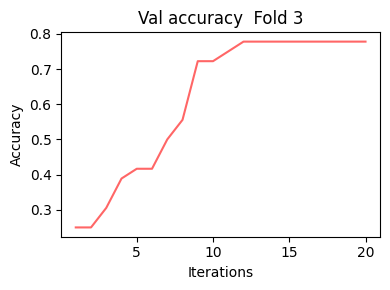

Processing Fold 4 ...


Epoch 1:   train/loss: 1.4026   valid/loss: 1.4809   train/acc: 0.2673   train/f1: 0.2757   valid/acc: 0.1667   valid/f1: 0.1876
Epoch 2:   train/loss: 1.2485   valid/loss: 1.4140   train/acc: 0.3522   train/f1: 0.3469   valid/acc: 0.3056   valid/f1: 0.3144
Epoch 3:   train/loss: 1.3833   valid/loss: 1.3629   train/acc: 0.4591   train/f1: 0.4722   valid/acc: 0.3611   valid/f1: 0.3677
Epoch 4:   train/loss: 1.1409   valid/loss: 1.3265   train/acc: 0.5597   train/f1: 0.5548   valid/acc: 0.3889   valid/f1: 0.3981
Epoch 5:   train/loss: 1.0443   valid/loss: 1.3044   train/acc: 0.6258   train/f1: 0.6373   valid/acc: 0.3611   valid/f1: 0.3703
Epoch 6:   train/loss: 1.0297   valid/loss: 1.2831   train/acc: 0.6981   train/f1: 0.6966   valid/acc: 0.4167   valid/f1: 0.4155
Epoch 7:   train/loss: 1.1115   valid/loss: 1.2460   train/acc: 0.7327   train/f1: 0.7265   valid/acc: 0.5000   valid/f1: 0.4972
Epoch 8:   train/loss: 1.0955   valid/loss: 1.2179   train/acc: 0.7799   train/f1: 0.7786   valid

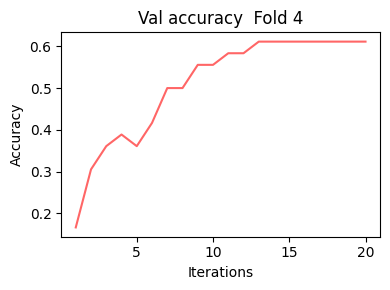

Processing Fold 5 ...


Epoch 1:   train/loss: 1.4027   valid/loss: 1.3666   train/acc: 0.2414   train/f1: 0.2345   valid/acc: 0.3429   valid/f1: 0.3392
Epoch 2:   train/loss: 1.3570   valid/loss: 1.3077   train/acc: 0.3197   train/f1: 0.3220   valid/acc: 0.4000   valid/f1: 0.4105
Epoch 3:   train/loss: 1.2238   valid/loss: 1.2488   train/acc: 0.4201   train/f1: 0.4182   valid/acc: 0.5429   valid/f1: 0.5496
Epoch 4:   train/loss: 1.2497   valid/loss: 1.1934   train/acc: 0.5235   train/f1: 0.5140   valid/acc: 0.6286   valid/f1: 0.6294
Epoch 5:   train/loss: 1.0728   valid/loss: 1.1593   train/acc: 0.5987   train/f1: 0.6016   valid/acc: 0.6286   valid/f1: 0.6294
Epoch 6:   train/loss: 0.9966   valid/loss: 1.1445   train/acc: 0.6458   train/f1: 0.6502   valid/acc: 0.6286   valid/f1: 0.6294
Epoch 7:   train/loss: 0.9664   valid/loss: 1.1302   train/acc: 0.7179   train/f1: 0.7178   valid/acc: 0.6571   valid/f1: 0.6603
Epoch 8:   train/loss: 0.9801   valid/loss: 1.1052   train/acc: 0.7774   train/f1: 0.7794   valid

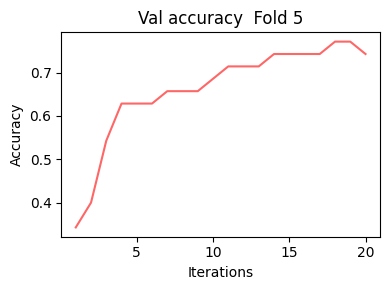

Processing Fold 6 ...


Epoch 1:   train/loss: 1.3896   valid/loss: 1.4093   train/acc: 0.2414   train/f1: 0.2431   valid/acc: 0.2571   valid/f1: 0.2590
Epoch 2:   train/loss: 1.4205   valid/loss: 1.3668   train/acc: 0.3386   train/f1: 0.3396   valid/acc: 0.2857   valid/f1: 0.2941
Epoch 3:   train/loss: 1.1934   valid/loss: 1.3401   train/acc: 0.4483   train/f1: 0.4522   valid/acc: 0.4000   valid/f1: 0.3963
Epoch 4:   train/loss: 1.2169   valid/loss: 1.3223   train/acc: 0.5517   train/f1: 0.5495   valid/acc: 0.3714   valid/f1: 0.3530
Epoch 5:   train/loss: 1.0757   valid/loss: 1.3086   train/acc: 0.6144   train/f1: 0.6147   valid/acc: 0.4000   valid/f1: 0.3946
Epoch 6:   train/loss: 1.0498   valid/loss: 1.2984   train/acc: 0.6928   train/f1: 0.6913   valid/acc: 0.3714   valid/f1: 0.3534
Epoch 7:   train/loss: 1.0130   valid/loss: 1.2818   train/acc: 0.7241   train/f1: 0.7271   valid/acc: 0.4286   valid/f1: 0.4248
Epoch 8:   train/loss: 1.0451   valid/loss: 1.2546   train/acc: 0.7837   train/f1: 0.7861   valid

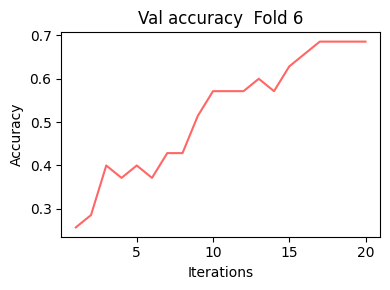

Processing Fold 7 ...


Epoch 1:   train/loss: 1.3426   valid/loss: 1.3726   train/acc: 0.2288   train/f1: 0.2328   valid/acc: 0.3429   valid/f1: 0.3343
Epoch 2:   train/loss: 1.3297   valid/loss: 1.3258   train/acc: 0.3386   train/f1: 0.3427   valid/acc: 0.3714   valid/f1: 0.3761
Epoch 3:   train/loss: 1.2597   valid/loss: 1.2718   train/acc: 0.4357   train/f1: 0.4302   valid/acc: 0.4286   valid/f1: 0.4286
Epoch 4:   train/loss: 1.2339   valid/loss: 1.2243   train/acc: 0.5329   train/f1: 0.5275   valid/acc: 0.4857   valid/f1: 0.4818
Epoch 5:   train/loss: 1.0715   valid/loss: 1.1889   train/acc: 0.5893   train/f1: 0.5886   valid/acc: 0.5429   valid/f1: 0.5361
Epoch 6:   train/loss: 1.0212   valid/loss: 1.1679   train/acc: 0.6395   train/f1: 0.6415   valid/acc: 0.5714   valid/f1: 0.5608
Epoch 7:   train/loss: 1.0512   valid/loss: 1.1359   train/acc: 0.6959   train/f1: 0.6942   valid/acc: 0.6000   valid/f1: 0.5961
Epoch 8:   train/loss: 1.0284   valid/loss: 1.1118   train/acc: 0.7461   train/f1: 0.7476   valid

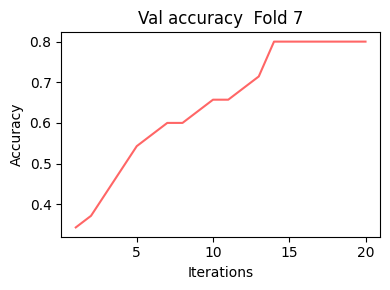

Processing Fold 8 ...


Epoch 1:   train/loss: 1.4773   valid/loss: 1.3638   train/acc: 0.2288   train/f1: 0.2389   valid/acc: 0.3143   valid/f1: 0.3223
Epoch 2:   train/loss: 1.4108   valid/loss: 1.2923   train/acc: 0.3260   train/f1: 0.3318   valid/acc: 0.4286   valid/f1: 0.4283
Epoch 3:   train/loss: 1.2566   valid/loss: 1.2252   train/acc: 0.4357   train/f1: 0.4378   valid/acc: 0.5143   valid/f1: 0.5092
Epoch 4:   train/loss: 1.2909   valid/loss: 1.1908   train/acc: 0.5392   train/f1: 0.5434   valid/acc: 0.5429   valid/f1: 0.5435
Epoch 5:   train/loss: 1.0508   valid/loss: 1.1614   train/acc: 0.6082   train/f1: 0.6100   valid/acc: 0.5429   valid/f1: 0.5477
Epoch 6:   train/loss: 1.1755   valid/loss: 1.1172   train/acc: 0.6646   train/f1: 0.6643   valid/acc: 0.6286   valid/f1: 0.6308
Epoch 7:   train/loss: 1.0503   valid/loss: 1.0706   train/acc: 0.7147   train/f1: 0.7123   valid/acc: 0.7143   valid/f1: 0.7137
Epoch 8:   train/loss: 1.0120   valid/loss: 1.0449   train/acc: 0.7649   train/f1: 0.7673   valid

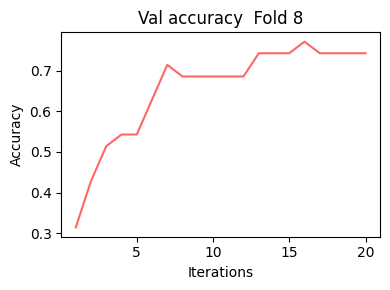

Processing Fold 9 ...


Epoch 1:   train/loss: 1.3414   valid/loss: 1.5525   train/acc: 0.2571   train/f1: 0.2524   valid/acc: 0.1429   valid/f1: 0.1366
Epoch 2:   train/loss: 1.3977   valid/loss: 1.4987   train/acc: 0.3574   train/f1: 0.3563   valid/acc: 0.1714   valid/f1: 0.1714
Epoch 3:   train/loss: 1.1228   valid/loss: 1.4463   train/acc: 0.4702   train/f1: 0.4698   valid/acc: 0.2286   valid/f1: 0.2326
Epoch 4:   train/loss: 1.2512   valid/loss: 1.3915   train/acc: 0.5611   train/f1: 0.5600   valid/acc: 0.3429   valid/f1: 0.3429
Epoch 5:   train/loss: 1.0701   valid/loss: 1.3425   train/acc: 0.6332   train/f1: 0.6278   valid/acc: 0.3429   valid/f1: 0.3429
Epoch 6:   train/loss: 1.0731   valid/loss: 1.2922   train/acc: 0.6959   train/f1: 0.6962   valid/acc: 0.4571   valid/f1: 0.4563
Epoch 7:   train/loss: 1.0084   valid/loss: 1.2480   train/acc: 0.7241   train/f1: 0.7191   valid/acc: 0.5429   valid/f1: 0.5394
Epoch 8:   train/loss: 1.0604   valid/loss: 1.2007   train/acc: 0.7837   train/f1: 0.7825   valid

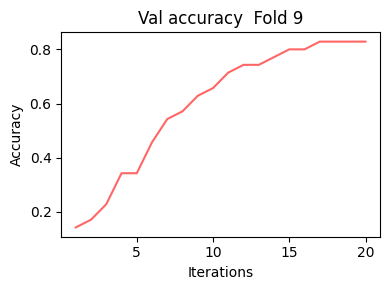

Processing Fold 10 ...


Epoch 1:   train/loss: 1.4204   valid/loss: 1.4683   train/acc: 0.2445   train/f1: 0.2444   valid/acc: 0.2571   valid/f1: 0.2406
Epoch 2:   train/loss: 1.2103   valid/loss: 1.4299   train/acc: 0.3511   train/f1: 0.3520   valid/acc: 0.2857   valid/f1: 0.2598
Epoch 3:   train/loss: 1.2685   valid/loss: 1.3908   train/acc: 0.4639   train/f1: 0.4625   valid/acc: 0.2857   valid/f1: 0.2622
Epoch 4:   train/loss: 1.1414   valid/loss: 1.3545   train/acc: 0.5549   train/f1: 0.5514   valid/acc: 0.3143   valid/f1: 0.3078
Epoch 5:   train/loss: 1.0840   valid/loss: 1.3215   train/acc: 0.6301   train/f1: 0.6322   valid/acc: 0.3714   valid/f1: 0.3581
Epoch 6:   train/loss: 1.0068   valid/loss: 1.2839   train/acc: 0.6614   train/f1: 0.6575   valid/acc: 0.4286   valid/f1: 0.4140
Epoch 7:   train/loss: 1.0055   valid/loss: 1.2477   train/acc: 0.7179   train/f1: 0.7182   valid/acc: 0.4857   valid/f1: 0.4726
Epoch 8:   train/loss: 0.9017   valid/loss: 1.2107   train/acc: 0.7743   train/f1: 0.7769   valid

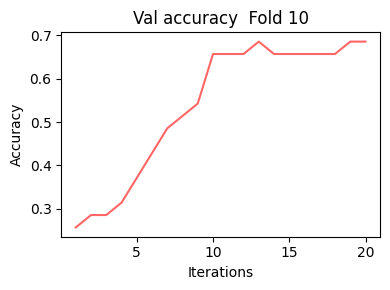

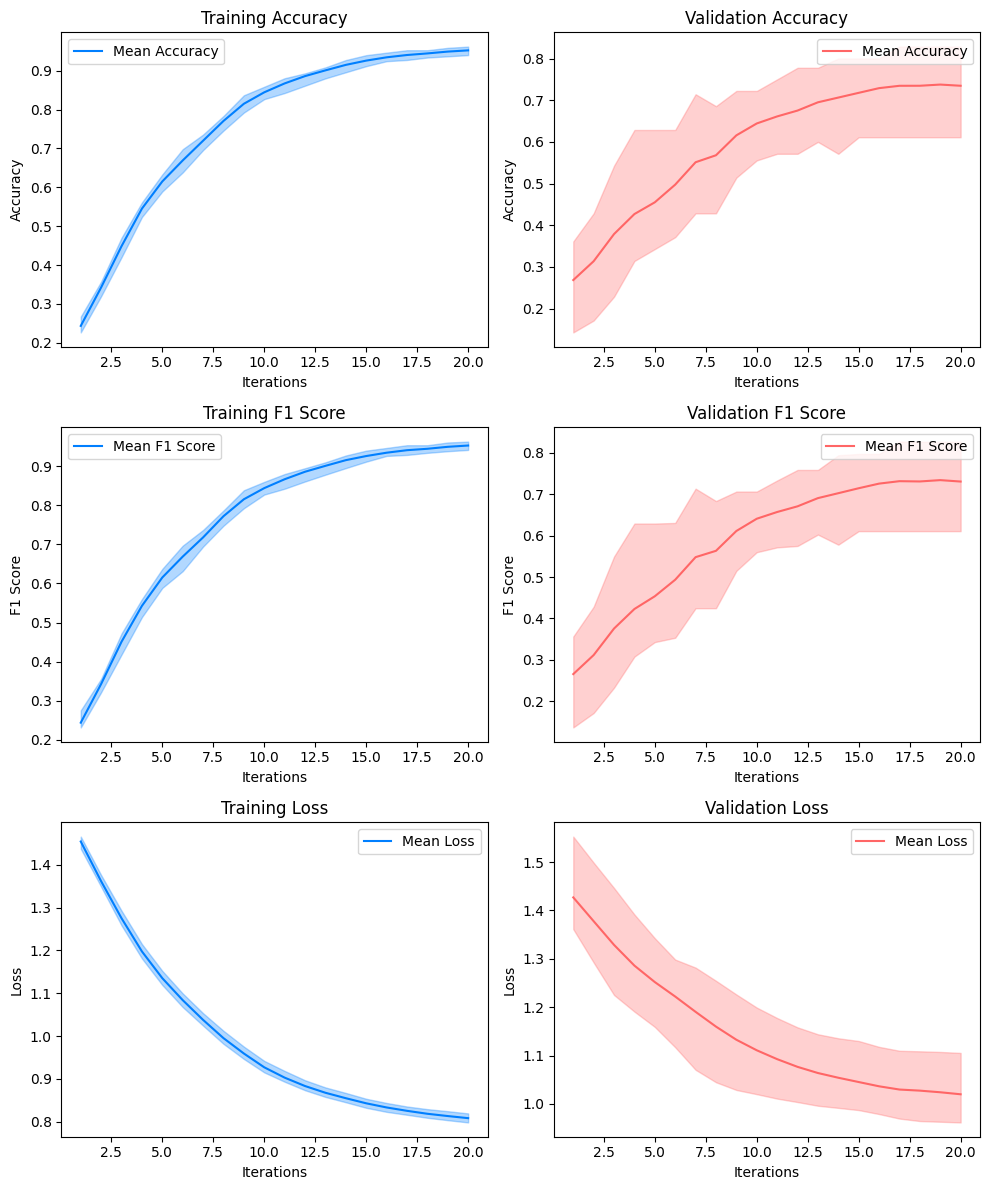

In [ ]:
cv = StratifiedKFold(n_splits=SPLIT, random_state=SEED, shuffle=True)
circuits_np = np.array(circuits, dtype=object)
targets_np = np.array(targets, dtype=object)

train_losses = []
val_losses = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []
train_accuracies = []
val_accuracies = []
train_f1 = []
val_f1 = []

for i, (train_index, val_index) in enumerate(cv.split(circuits_np, targets_np.argmax(1))):

    print(f'Processing Fold {i+1} ...')

    train_fold = Dataset(circuits_np[train_index], targets_np[train_index], batch_size=BATCH_SIZE)
    val_fold = Dataset(circuits_np[val_index], targets_np[val_index])

    model = QuantumModel.from_diagrams(circuits)
    model.initialise_weights()

    trainer = PytorchTrainer(
        model=model,
        loss_function=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.AdamW,
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS,
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        verbose='text',
        seed=SEED
    )

    trainer.fit(train_fold, val_fold, log_interval=25, early_stopping_interval=EARLY_STOPPING)

    train_losses.append(trainer.train_epoch_costs)
    val_losses.append(trainer.val_costs)

    train_precisions.append(trainer.train_eval_results['prec'])
    val_precisions.append(trainer.val_eval_results['prec'])

    train_recalls.append(trainer.train_eval_results['rec'])
    val_recalls.append(trainer.val_eval_results['rec'])

    train_accuracies.append(trainer.train_eval_results['acc'])
    val_accuracies.append(trainer.val_eval_results['acc'])

    train_f1.append(trainer.train_eval_results['f1'])
    val_f1.append(trainer.val_eval_results['f1'])


range_ = np.arange(1, len(trainer.train_epoch_costs) + 1)

mean_train_loss = np.mean(train_losses, axis=0)
min_train_loss = np.min(train_losses, axis=0)
max_train_loss = np.max(train_losses, axis=0)

mean_val_loss = np.mean(val_losses, axis=0)
min_val_loss = np.min(val_losses, axis=0)
max_val_loss = np.max(val_losses, axis=0)


mean_train_precision = np.mean(train_precisions, axis=0)
min_train_precision = np.min(train_precisions, axis=0)
max_train_precision = np.max(train_precisions, axis=0)

mean_val_precision = np.mean(val_precisions, axis=0)
min_val_precision = np.min(val_precisions, axis=0)
max_val_precision = np.max(val_precisions, axis=0)


mean_train_recall = np.mean(train_recalls, axis=0)
min_train_recall = np.min(train_recalls, axis=0)
max_train_recall = np.max(train_recalls, axis=0)

mean_val_recalls = np.mean(val_recalls, axis=0)
min_val_recalls = np.min(val_recalls, axis=0)
max_val_recalls = np.max(val_recalls, axis=0)


mean_train_accuracy = np.mean(train_accuracies, axis=0)
min_train_accuracy = np.min(train_accuracies, axis=0)
max_train_accuracy = np.max(train_accuracies, axis=0)

mean_val_accuracy = np.mean(val_accuracies, axis=0)
min_val_accuracy = np.min(val_accuracies, axis=0)
max_val_accuracy = np.max(val_accuracies, axis=0)


mean_train_f1 = np.mean(train_f1, axis=0)
min_train_f1 = np.min(train_f1, axis=0)
max_train_f1 = np.max(train_f1, axis=0)

mean_val_f1 = np.mean(val_f1, axis=0)
min_val_f1 = np.min(val_f1, axis=0)
max_val_f1 = np.max(val_f1, axis=0)


fig, axes = plt.subplots(5, 2, figsize=(12, 18))

axes[0, 0].set_title('Training Accuracy')
axes[0, 0].set_xlabel('Iterations')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].plot(range_, mean_train_accuracy, color=custom_primary, label='Mean Accuracy')
axes[0, 0].fill_between(range_, min_train_accuracy, max_train_accuracy, color=custom_primary, alpha=0.3)
axes[0, 0].legend()

axes[0, 1].set_title('Validation Accuracy')
axes[0, 1].set_xlabel('Iterations')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].plot(range_, mean_val_accuracy, color=custom_secondary, label='Mean Accuracy')
axes[0, 1].fill_between(range_, min_val_accuracy, max_val_accuracy, color=custom_secondary, alpha=0.3)
axes[0, 1].legend()

axes[1, 0].set_title('Training F1 Score')
axes[1, 0].set_xlabel('Iterations')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].plot(range_, mean_train_f1, color=custom_primary, label='Mean F1 Score')
axes[1, 0].fill_between(range_, min_train_f1, max_train_f1, color=custom_primary, alpha=0.3)
axes[1, 0].legend()

axes[1, 1].set_title('Validation F1 Score')
axes[1, 1].set_xlabel('Iterations')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].plot(range_, mean_val_f1, color=custom_secondary, label='Mean F1 Score')
axes[1, 1].fill_between(range_, min_val_f1, max_val_f1, color=custom_secondary, alpha=0.3)
axes[1, 1].legend()

axes[2, 0].set_title('Training Precision')
axes[2, 0].set_xlabel('Iterations')
axes[2, 0].set_ylabel('Precision')
axes[2, 0].plot(range_, mean_train_precision, color=custom_primary, label='Mean Precision')
axes[2, 0].fill_between(range_, min_train_precision, max_train_precision, color=custom_primary, alpha=0.3)
axes[2, 0].legend()

axes[2, 1].set_title('Validation Precision')
axes[2, 1].set_xlabel('Iterations')
axes[2, 1].set_ylabel('Precision')
axes[2, 1].plot(range_, mean_val_precision, color=custom_secondary, label='Mean Precision')
axes[2, 1].fill_between(range_, min_val_precision, max_val_precision, color=custom_secondary, alpha=0.3)
axes[2, 1].legend()

axes[3, 0].set_title('Training Recall')
axes[3, 0].set_xlabel('Iterations')
axes[3, 0].set_ylabel('Recall')
axes[3, 0].plot(range_, mean_train_recall, color=custom_primary, label='Mean Recall')
axes[3, 0].fill_between(range_, min_train_recall, max_train_recall, color=custom_primary, alpha=0.3)
axes[3, 0].legend()

axes[3, 1].set_title('Validation Recall')
axes[3, 1].set_xlabel('Iterations')
axes[3, 1].set_ylabel('Recall')
axes[3, 1].plot(range_, mean_val_recalls, color=custom_secondary, label='Mean Recall')
axes[3, 1].fill_between(range_, min_val_recalls, max_val_recalls, color=custom_secondary, alpha=0.3)
axes[3, 1].legend()

axes[4, 0].set_title('Training Loss')
axes[4, 0].set_xlabel('Iterations')
axes[4, 0].set_ylabel('Loss')
axes[4, 0].plot(range_, mean_train_loss, color=custom_primary, label='Mean Loss')
axes[4, 0].fill_between(range_, min_train_loss, max_train_loss, color=custom_primary, alpha=0.3)
axes[4, 0].legend()

axes[4, 1].set_title('Validation Loss')
axes[4, 1].set_xlabel('Iterations')
axes[4, 1].set_ylabel('Loss')
axes[4, 1].plot(range_, mean_val_loss, color=custom_secondary, label='Mean Loss')
axes[4, 1].fill_between(range_, min_val_loss, max_val_loss, color=custom_secondary, alpha=0.3)
axes[4, 1].legend()

plt.tight_layout()
plt.savefig(f"/content/drive/MyDrive/Tesi/Master-Thesis/figures/classical/multi.pdf", format="pdf", bbox_inches="tight")
plt.show()